<font size = 8> Barnacle detenction using Image Processing. 

<font size=4> In this notebook, I explore traditional computer vision and image processing techniques to develop a pipeline for counting barnacles. The process involves a sequence of steps including filtering, binarization, morphological transformations, and contour detection.

I also implement popular methods such as Otsu's thresholding for binarization and the Watershed algorithm for image segmentation. Finally, by identifying and counting the distinct contour objects, I estimate the number of barnacles in the given image.

<font size = 5> Importing necessary libraries

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt 
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image
from helpers import *

<font size= 5> Grayscaling the image and reducing noise 

<font size=4> The following pipeline is demonstrated using one of the images provided for the challenge. Feel free to test it on other images as well. However, a quick disclaimer: since this technique is entirely manual and does not leverage any state-of-the-art computer vision models specifically trained to count barnacles, it may produce false positives on images that do not contain barnacles. This pipeline assumes that the input images, like those provided in the challenge, consist solely of barnacle-covered surfaces.

In [5]:
THRESHOLD =0.27 #Optimal threshold decided based on a manual grid search across 20+ different values
image_path = "images/sample_image2.png"

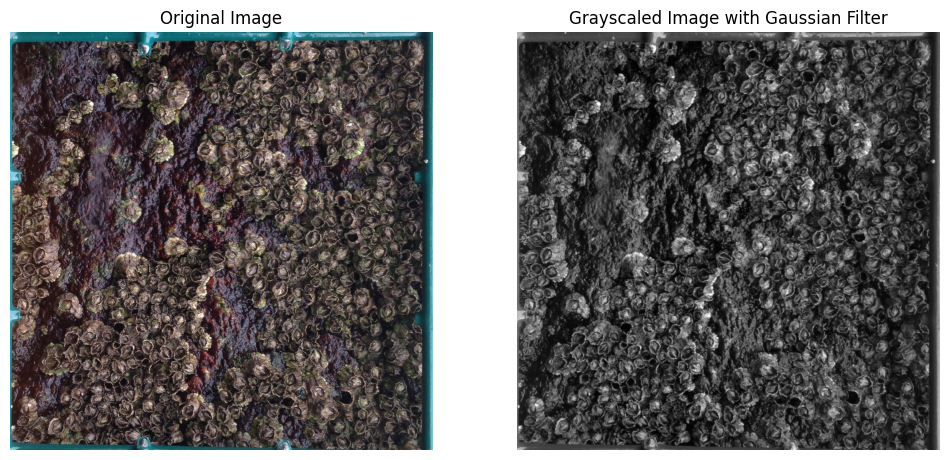

In [6]:
image = Image.open(image_path).convert("RGB")
grayscale_image = image.convert("L")
image_array = np.array(grayscale_image)
gaussian_filtered_image = gaussian_filter(image_array, sigma=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(gaussian_filtered_image, cmap= 'gray')
ax[1].set_title('Grayscaled Image with Gaussian Filter')
ax[1].axis('off')

plt.show()

<font size= 6> Applying Otsu's Thresholding

<font size = 4>Otsu's method is a popular algorithm for automatic image thresholding. The 'optimal' threshold calulcated using Otsu's method is used to convert a grayscale image into a binary image.

Obtained threshold: 76.0


(np.float64(-0.5), np.float64(1675.5), np.float64(1655.5), np.float64(-0.5))

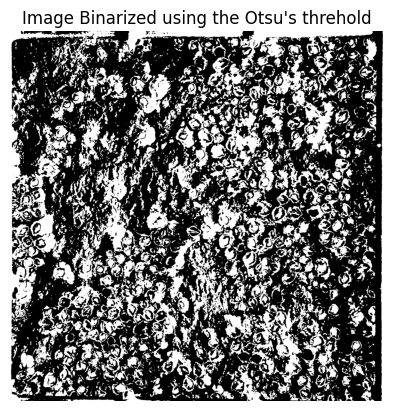

In [7]:
otsu_threshold, image_after_otsu = cv2.threshold(
gaussian_filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU, 
)
print("Obtained threshold:", otsu_threshold)

plt.imshow(image_after_otsu, cmap= 'gray')
plt.title("Image Binarized using the Otsu's threhold")
plt.axis('off')


<font size =5> Removing noise

(np.float64(-0.5), np.float64(1675.5), np.float64(1655.5), np.float64(-0.5))

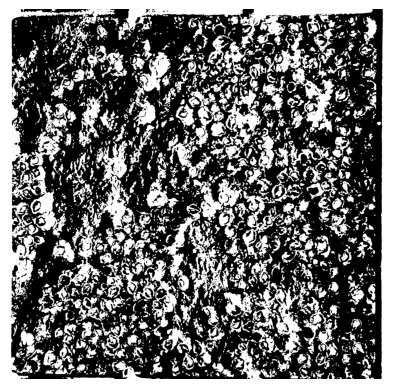

In [8]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
cleaned_image = cv2.morphologyEx(image_after_otsu, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=1)
plt.imshow(cleaned_image, cmap='gray')
plt.axis('off')

<font size=5> Morphological Transformations

<font size=4> Several morphological operations are applied to the image. First, erosion is used to shrink objects and eliminate noise. Then, dilation is performed to expand the remaining structures.

After these steps, a distance transform is applied to compute the distance of each white pixel from the nearest black pixel. This distance map helps distinguish the definite foreground area from the uncertain region, which is useful for segmentation tasks. The threshold value used to separate these areas is 0.27, chosen after performing a grid search over more than 20 different threshold values.

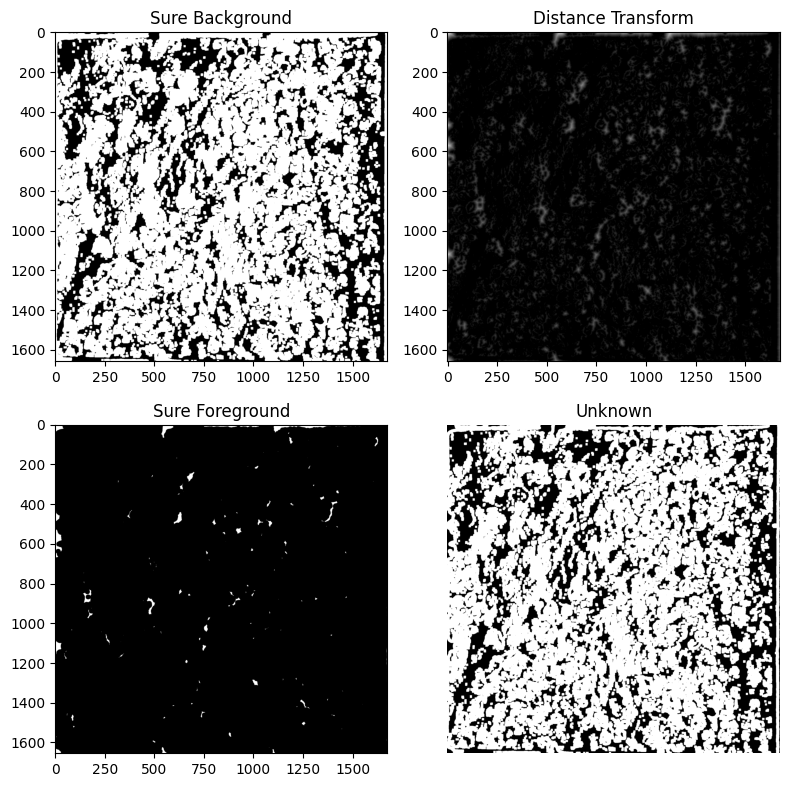

In [9]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# sure background area
# intermediary_bg = cv2.erode(cleaned_image, kernel, iterations=3)
sure_bg = cv2.dilate(cleaned_image, kernel, iterations=4)
axes[0,0].imshow(sure_bg, cmap='gray') # Corrected line
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(cleaned_image, cv2.DIST_L2,5)
axes[0,1].imshow(dist, cmap='gray') # Corrected line
axes[0, 1].set_title('Distance Transform')

# foreground area
ret, sure_fg = cv2.threshold(dist, THRESHOLD * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
axes[1,0].imshow(sure_fg, cmap='gray') # Corrected line
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
axes[1,1].imshow(unknown, cmap='gray') # Corrected line
axes[1, 1].set_title('Unknown')

plt.tight_layout() # Adjust layout to prevent titles/labels from overlapping
plt.axis('off')
plt.show()

<font size = 5> Creating Marker Image

<font size=4> Now, each distinct object identified in the sure-foreground image is assigned a unique marker. After that, all marker values are incremented by 1, which is a common practice to reserve the value 0 for the unknown region when applying the Watershed algorithm. 

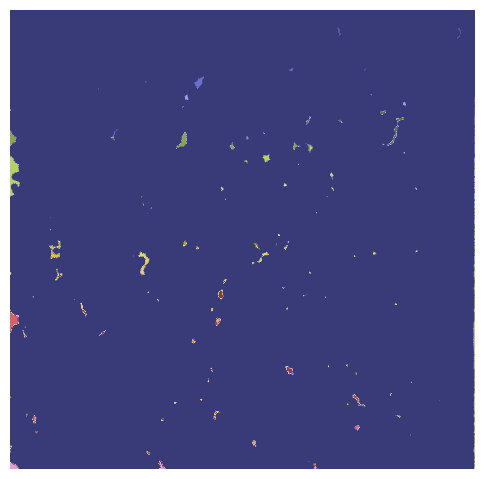

In [10]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

<font size =5> Applying Watershed Algorithm

 <font size  = 4> The Watershed Algorithm is a powerful image processing technique used for segmentation, particularly for separating touching or overlapping objects. Once the algorithm is applied, contours are drawn on the original image for better visualisation of how the algorithm is identifying different objects (barnacles) within the image.

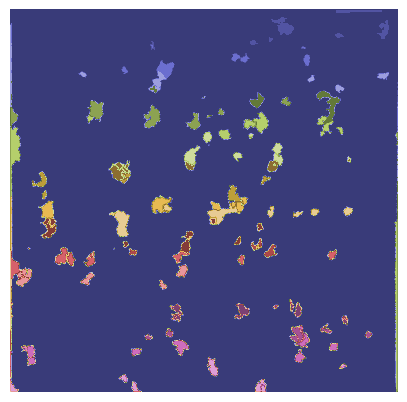

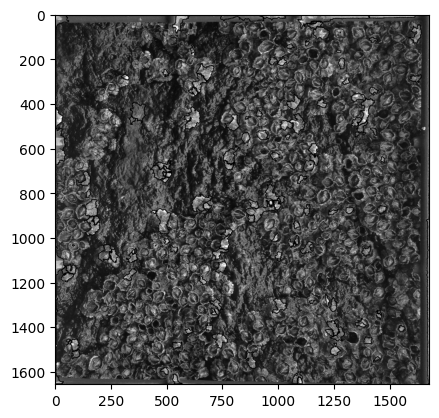

In [11]:
# watershed Algorithm
img_array = np.array(image).astype(np.uint8)
markers = cv2.watershed(img_array, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
plt.savefig("my_image.png")
ax.axis('off')
plt.show()


labels = np.unique(markers)

barnacles = []
for label in labels[2:]:  

# Create a binary image in which only the area of the label is in the foreground and the rest of the image is in the background   
    target = np.where(markers == label, 255, 0).astype(np.uint8)
  
  # Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    barnacles.append(contours[0])

# Draw the outline
image = cv2.drawContours(image_array, barnacles, -1, color=(0, 23, 223), thickness=2)
plt.imshow(image, cmap ='grey')

In [12]:
print(f"The number of barnacles is {len(barnacles)}")

The number of barnacles is 164


<FONT SIZE =6> Calulating the actual number of Barnacles

In [13]:
image = cv2.imread("sample_image1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
connectivity= 8 

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
output = cv2.connectedComponentsWithStats(
	thresh, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

In [ ]:
all_components_output = image.copy()

for i in range(0, numLabels):
    
    if i == 0:
        text = "examining component {}/{} (background)".format(i + 1, numLabels)
        # Often you would use `continue` here to skip processing the background
        # continue
    else:
        text = "examining component {}/{}".format(i + 1, numLabels)

    # print a status message update for the current connected component
    print("[INFO] {}".format(text))

    # extract the connected component statistics and centroid for the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]

    # Draw on a temporary copy for showing individual component
    current_component_output = image.copy()
    cv2.rectangle(current_component_output, (x, y), (x + w, y + h), (0, 255, 0), 3) # Green rectangle
    cv2.circle(current_component_output, (int(cX), int(cY)), 4, (0, 0, 255), -1) # Red circle for centroid

    # Also draw on the cumulative output image
    if i > 0: # Don't draw background's bbox on cumulative image
        cv2.rectangle(all_components_output, (x, y), (x + w, y + h), (0, 255, 0), 2) # Thinner green rectangle
        cv2.circle(all_components_output, (int(cX), int(cY)), 3, (0, 0, 255), -1)

    componentMask = (labels == i).astype("uint8") * 255

    # show our output image and connected component mask
    cv2.imshow("Output (Current Component)", current_component_output)
    cv2.imshow("Connected Component Mask", componentMask)

    # Wait for a key press (or a short time).
    # Using 0 for user control, or a small positive integer for animation.
    # To stop the loop, press 'q'.


# Show the image with all components highlighted at the end (optional)


[INFO] examining component 1/7523 (background)
[INFO] examining component 2/7523
[INFO] examining component 3/7523
[INFO] examining component 4/7523
[INFO] examining component 5/7523
[INFO] examining component 6/7523
[INFO] examining component 7/7523
[INFO] examining component 8/7523
[INFO] examining component 9/7523
[INFO] examining component 10/7523
[INFO] examining component 11/7523
[INFO] examining component 12/7523
[INFO] examining component 13/7523
[INFO] examining component 14/7523
[INFO] examining component 15/7523
[INFO] examining component 16/7523
[INFO] examining component 17/7523
[INFO] examining component 18/7523
[INFO] examining component 19/7523
[INFO] examining component 20/7523
[INFO] examining component 21/7523
[INFO] examining component 22/7523
[INFO] examining component 23/7523
[INFO] examining component 24/7523
[INFO] examining component 25/7523
[INFO] examining component 26/7523
[INFO] examining component 27/7523
[INFO] examining component 28/7523
[INFO] examining

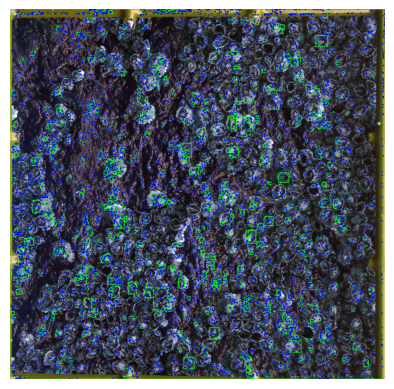

In [ ]:
all_components_output_array = np.array 
plt.imshow(all_components_output)
plt.axis("off")
plt.show()

<font size =6> Accuracy Metrics Across All Three Pipelines.

<font size =4> The image processing pipeline has been applied, and the number of barnacles have been counted. It is now time to calculate the accuracy of the models and how they perform. For convenience, the accuracy statistics of all the pipelines will be presented in this notebook. More specifically, the following will be presented: 

1. Accuracy of the image processing model across different Thresholding levelsv(for both images )
2. Comparison of trained model against the API model 
3. Accuracy of all three pipelines with their best performing parameters

In [20]:
thresholds = [0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28, 0.29, 0.30,0.31,0.32,0.33,0.34,0.355,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5]

barnacles= []
for threshold in thresholds: 
    barnacle = traditional_cv_medthod('images/sample_image.png', threshold)
    barnacles.append(barnacle)

In [21]:
thresholds = [0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28, 0.29, 0.30,0.31,0.32,0.33,0.34,0.355,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5]

barnacles_2= []
for threshold in thresholds: 
    barnacle = traditional_cv_medthod('images/sample_image2.png', threshold)
    barnacles_2.append(barnacle)

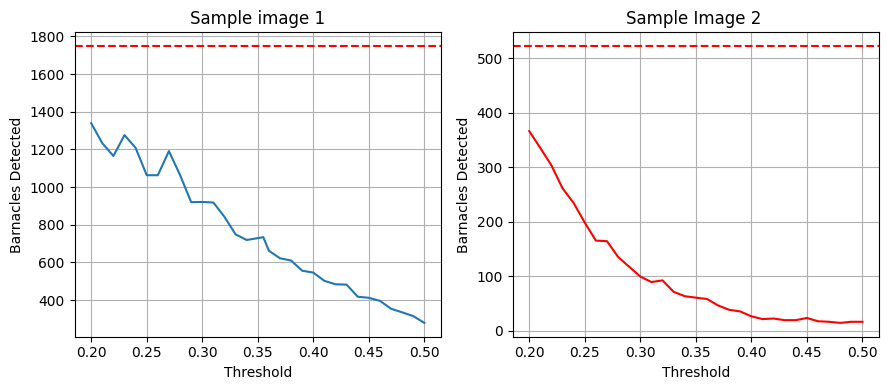

In [ ]:
#To avoid running the entire loop again for the result data
barnacles = [1339, 1233, 1165, 1276, 1208, 1063, 1063, 1191, 1064, 920, 921, 918, 842, 749, 719, 734, 662, 622, 610, 556, 546, 502, 484, 482, 418, 412, 396, 354, 335, 315, 279]
barnacles_2 = [366, 335, 303, 261, 234, 198, 165, 164, 135, 117, 99, 89, 92, 71, 63, 59, 58, 46, 38, 35, 26, 21, 22, 19, 19, 23, 17, 16, 14, 16, 16]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,4))

ax1.plot(thresholds, barnacles)
ax1.set_title('Sample image 1')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Barnacles Detected')
ax1.grid()
ax1.axhline(y= 1748, color='r', linestyle='--', label='Actual number of Barnacles')


ax2.plot(thresholds, barnacles_2, color='red')
ax2.set_title('Sample Image 2 ')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Barnacles Detected')
ax2.axhline(y= 522, color='r', linestyle='--', label='Actual number of Barnacles')
ax2.grid()

plt.tight_layout()
plt.show()


<font size =4> Here, the threshold represents the threshold applied to distinguish the sure foreground area from the unknown area. This is done after the step of performing opening (erosion followed by dilation). This is an important metric as it largely determines what area to consider sure fureground what to not. Thre threshold dictates what propotion of the maximum distance between a white pixel and black pixel in the given binarized image should be considered. For example, if the threshold is set to be 0.2, any pixel farther than 20% of the maximum distance from black pixels is considered to be sure foreground. 

Normally, the threshold is set to 0.5 for regular shapes. However, as barnacles have irregular shapes and stretch along some axes more than the others, I found it useful to run a grid search across these threshold values.

As expected, the pipeline performs best on the lowest threshold and performs worse as threshold increases. Further analysis can be done by to calculate which threshold gives the highest number of True positives.  